# Demo for "Prediction: Regression and Classification" Lecture
*Prepared by Philippe Boileau*

This notebook contains the code for perfoming the analyses for the case studies introduced during the "Prediction: Classification and Regression" lecture. 

**Note.** Prediction methods such as classification and regression trees typically have many tuning parameters/inputs and output values. There are also differences in implementation across software packages. Make sure to consult the documentation to understand how the predictors are built and how to interpret the results. Try modifying tuning parameters for each of the predictors below to see how this influences the results!

In [1]:
import sys
!{sys.executable} -m pip install tabulate

import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

from sklearn.model_selection import train_test_split

from IPython.display import HTML, display
import tabulate

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

You should consider upgrading via the '/Users/ryan_kim/Documents/programming/ds/data/bin/python -m pip install --upgrade pip' command.


In [2]:
# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

## Predicting Rent Using Craigslist Data

Using data recently collected from Craigslist, we will attempt to predict the rent price of apartments in Berkeley based on the following five features: Square footage, number of bedrooms, number of bathrooms, latitude, and longitiude. This is a regression problem since the outcome of interest (rent price) is continuous. To accomplish this task, we will fit the following families of models to the data: Linear regression, regression trees, and Random Forests. 

We randomly split the data into a learning set (80% of observations) to train the predictors and into a test set (20% of observations) to evaluate and compare their performances.

The Craigslist data are prepared for analysis in the cells below. The results in this notebook will differ from the results shown in lecture due to the randomness induced by splitting the data into learning and test sets. Try changing the random seed to see how this will affect the results.

In [3]:
# load data
craigslist_df = pd.read_csv("craigslist.csv")

# select response and required features
craigslist_df = craigslist_df.loc[:, ["price", "sqft", "bedrooms", "bath", "lat", "long"]]

# drop all observations with missing feature values
craigslist_df.dropna(inplace=True)

# remove the outliers in long and lat variables.
# outliers are defined as values below Q1-1.5*IQR or above Q3+1.5*IQR
# where Qi is the i^th quartile and IQR is the interquartile range
Q1_lat = craigslist_df["lat"].quantile(0.25)
Q3_lat = craigslist_df["lat"].quantile(0.75)
IQR_lat = Q3_lat - Q1_lat
Q1_long = craigslist_df["long"].quantile(0.25)
Q3_long = craigslist_df["long"].quantile(0.75)
IQR_long = Q3_long - Q1_long
craigslist_df = craigslist_df.loc[(craigslist_df["lat"] > Q1_lat - 1.5*IQR_lat) & 
                                  (craigslist_df["lat"] < Q3_lat + 1.5*IQR_lat) &
                                  (craigslist_df["long"] > Q1_long - 1.5*IQR_long) & 
                                  (craigslist_df["long"] < Q3_long + 1.5*IQR_long)]

# remove observations with square footage below 100 or above 500
craigslist_df = craigslist_df.loc[(craigslist_df["sqft"] >= 100) & (craigslist_df["sqft"] <= 5000)]

craigslist_df.shape
# partition data into test and learning set
np.random.seed(210)
X = craigslist_df.loc[:, ["sqft", "bedrooms", "bath", "lat", "long"]]
y = craigslist_df.loc[:, "price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

### Linear Regression

In this section, we fit a linear regression function over all five covariates using the ordinary least squares method.

In [4]:
# import the linear model from sklearn
from sklearn import linear_model as lm
from sklearn.metrics import r2_score

# initialize model
linear_model = lm.LinearRegression(fit_intercept=True)

# fit the model
linear_model.fit(X_train, y_train)

# compute the fitted and predicted values of the rental price
y_fitted = linear_model.predict(X_train)
y_predicted = linear_model.predict(X_test)

# compute the learning and test set MSEs
mse_train = np.mean((y_fitted - y_train)**2)
mse_test = np.mean((y_predicted - y_test)**2)

# compute the learning and test sets' coefficients of determination 
R2_train = r2_score(y_train, y_fitted)
R2_test = r2_score(y_test, y_predicted)

# display the results in a table
table = [["Dataset", "MSE", "$R^2$"],
         ["Learning", round(mse_train, 3), round(R2_train, 3)],
         ["Test", round(mse_test, 3), round(R2_test, 3)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Dataset,MSE,$R^2$
Learning,412808.949,0.513
Test,437111.858,0.439


The relationships between the fitted rent values and the features are visualized in the following cells.

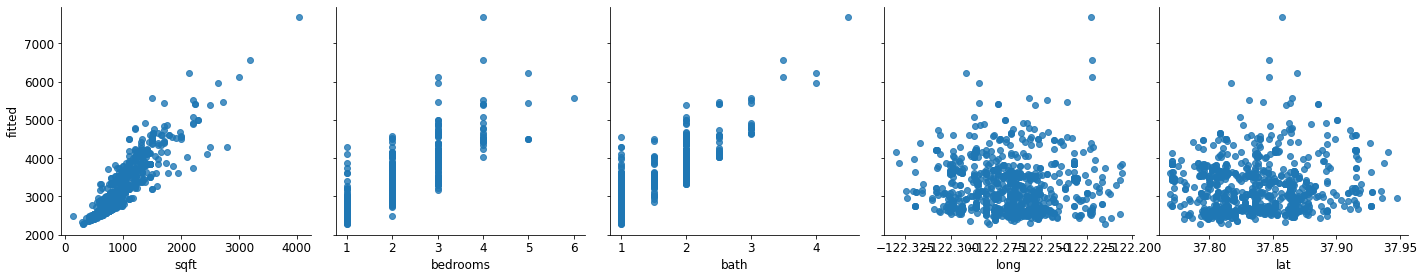

In [5]:
# create new dataframe and plot the results
results_df = X_train.copy()
results_df["fitted"] = y_fitted
g = sns.PairGrid(results_df, y_vars="fitted", x_vars=["sqft", "bedrooms", "bath", "long", "lat"], height=4)
g.map(sns.regplot, fit_reg=False);

Now try using a subset of the features to see how this affects the learning and test set MSEs and $R^2$s.

In [6]:
# different set of features
new_cov = ["sqft", "lat", "long"]
X_train_new = X_train.loc[:, new_cov]
X_test_new = X_test.loc[:, new_cov]

# fit the model on a different set of covariates
linear_model.fit(X_train_new, y_train)

# compute the fitted and predicted values of the rental price
y_fitted = linear_model.predict(X_train_new)
y_predicted = linear_model.predict(X_test_new)

# compute the learning and test set MSEs
mse_train = np.mean((y_fitted - y_train)**2)
mse_test = np.mean((y_predicted - y_test)**2)

# compute the learning and test sets' coefficients of determination 
R2_train = r2_score(y_train, y_fitted)
R2_test = r2_score(y_test, y_predicted)

# display the results in a table
table = [["Dataset", "MSE", "$R^2$"],
         ["Learning", round(mse_train, 3), round(R2_train, 3)],
         ["Test", round(mse_test, 3), round(R2_test, 3)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Dataset,MSE,$R^2$
Learning,491448.203,0.421
Test,499890.462,0.358


### Regression Trees

In this section, a regression tree is fit to the learning data using the CART method. The maximum depth of the tree is set to 5.

In [7]:
# import the CART method
from sklearn import tree

# initialize mode
clf = tree.DecisionTreeRegressor(max_depth=5)

# fit the model
clf = clf.fit(X_train, y_train)

# compute the fitted and predicted values of the rental price
y_fitted = clf.predict(X_train)
y_predicted = clf.predict(X_test)

# compute the learning and test set MSEs
mse_train = np.mean((y_fitted - y_train)**2)
mse_test = np.mean((y_predicted - y_test)**2)

# compute the learning and test sets' coefficients of determination 
R2_train = r2_score(y_train, y_fitted)
R2_test = r2_score(y_test, y_predicted)

# display the results in a table
table = [["Dataset", "MSE", "$R^2$"],
         ["Learning", round(mse_train, 3), round(R2_train, 3)],
         ["Test", round(mse_test, 3), round(R2_test, 3)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Dataset,MSE,$R^2$
Learning,260917.003,0.692
Test,341316.238,0.562


Next, we determine the feature importances. There are many ways to assess each features importance, but `sklearn` uses Gini importance (also called "mean decrease in impurity") in classification and regression trees, as well as in Random Forests. This is a normalized measurement; the importances sum to 1.

In [8]:
table = [X_train.columns.values,
         np.round(clf.feature_importances_, 3)]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

sqft,bedrooms,bath,lat,long
0.248,0.037,0.493,0.131,0.091


Text(0.5, 0, 'Relative Importance')

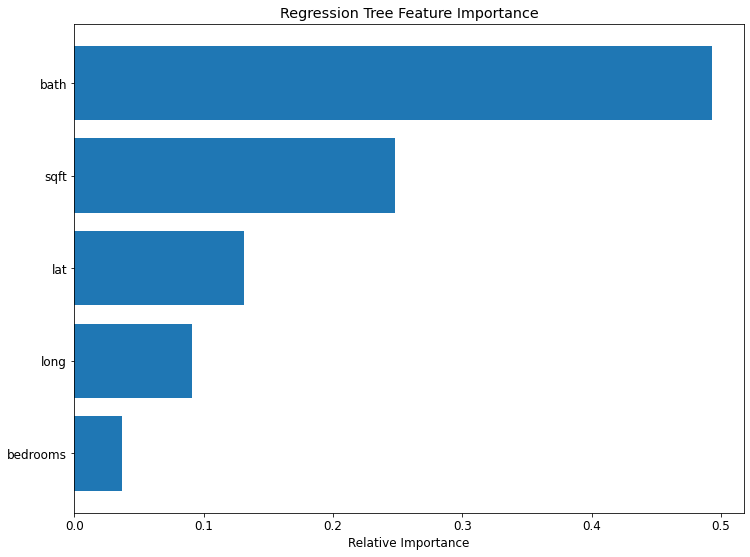

In [9]:
indices = np.argsort(table[1])
plt.title("Regression Tree Feature Importance")
plt.barh(y = range(len(indices)), width = table[1][indices],align="center")
plt.yticks(range(len(indices)), [table[0][i] for i in indices])
plt.xlabel("Relative Importance")

In [11]:
# plot the the regression tree
# !conda install -y graphviz
import graphviz 

dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)
graph

ModuleNotFoundError: No module named 'graphviz'

Try changing the number of features and the maximum depth of the tree in the previous cells. How does this affect the results? What other tuning parameters could you tweak to improve the performance of the tree? Check out the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor) for ideas.

### Random Forests

This section uses Random Forests to predict rental costs of apartments in Berkeley. The maximum depth of each tree is again set to 5 and there are 100 trees in total.

In [ ]:
# import random forest model from sklearn
from sklearn.ensemble import RandomForestRegressor

# set the hyperparameters
rfor = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)

# fit the random forest to the learning data
rfor = rfor.fit(X_train, y_train)

# compute the fitted and predicted values of the rental price
y_fitted = rfor.predict(X_train)
y_predicted = rfor.predict(X_test)

# compute the learning and test set MSEs
mse_train = np.mean((y_fitted - y_train)**2)
mse_test = np.mean((y_predicted - y_test)**2)

# compute the learning and test sets' coefficients of determination 
R2_train = r2_score(y_train, y_fitted)
R2_test = r2_score(y_test, y_predicted)

# display the results in a table
table = [["Dataset", "MSE", "$R^2$"],
         ["Learning", round(mse_train, 3), round(R2_train, 3)],
         ["Test", round(mse_test, 3), round(R2_test, 3)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

The variable importances are shown in the following table and figure.

In [ ]:
table = [X_train.columns.values,
         np.round(rfor.feature_importances_, 3)]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

In [ ]:
indices = np.argsort(table[1])
plt.title("Random Forests Feature Importance")
plt.barh(y = range(len(indices)), width = table[1][indices],align="center")
plt.yticks(range(len(indices)), [table[0][i] for i in indices])
plt.xlabel("Relative Importance")

Random Forests clearly outperforms a single regression tree and linear regression in terms of test set MSE and $R^2$. However, the importance of the features in the Random Forests and the regression tree are very similar.

Try playing with the tuning parameters to see how this affects the Random Forests' performance. The documentation can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

## Classifying MNIST Handwritten Digits

In [ ]:
## import sklearn.datasets
mnist = sklearn.datasets.load_digits()

# format mnist data bunch into a dataframe and an array
y = pd.Series(mnist.target).astype('int').astype('category')
X = pd.DataFrame(mnist.data)

# split the data into learning and testing sets
np.random.seed(14)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.143, shuffle = True)

### Logistic Regression

First, a multinomial logistic regression model is fit to the data.

In [ ]:
# initialize the multinomial logistic regression model
lr = lm.LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=4000)

# fit the model to the digits data
lr.fit(X_train, y_train)

# predict the labels on the learning and testing data
class_fitted = lr.predict(X_train)
class_pred = lr.predict(X_test)

# compute the accuracies
train_acc = sum(class_fitted == y_train)/len(y_train)
test_acc = sum(class_pred == y_test)/len(y_test)

# print the results
table = [["Dataset", "Accuracy"],
         ["Learning", round(train_acc, 3)],
         ["Test", round(test_acc, 3)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

The multinomial logistic regression function classifies the handwritten digits with exceptional accuracy in the test set. The confusion matrix of the test set is presented in the following cell.

In [ ]:
conf_mat_test = sklearn.metrics.confusion_matrix(y_test, class_pred)
df_cm = pd.DataFrame(conf_mat_test, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
cmap = sns.cubehelix_palette(light=0.95, as_cmap=True)
sns.heatmap(df_cm, annot=True, cmap = cmap);

### k-Nearest Neighbours (kNN)

The second method used to clasify the MNIST handwritten digits data is k-nearest neighbours (kNN). The parameter k specifying the number of neighbours is set to 100.

In [ ]:
# import model from sklearn
from sklearn.neighbors import KNeighborsClassifier

# initialize the model
neigh = KNeighborsClassifier(n_neighbors=100)

# fit the model to the learning data
neigh.fit(X_train, y_train)

# predict the labels on the learning and testing data
class_fitted = neigh.predict(X_train)
class_pred = neigh.predict(X_test)

# compute the accuracies
train_acc = sum(class_fitted == y_train)/len(y_train)
test_acc = sum(class_pred == y_test)/len(y_test)

# print the results
table = [["Dataset", "Accuracy"],
         ["Learning", round(train_acc, 3)],
         ["Test", round(test_acc, 3)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

The kNN classification algorithm does a great job of predicting the handwritten digits! Sometimes the simplest models perform the best. What happens when you change the `n_neighbors` parameter to 10? To 1000? How can you explain the change in results? What would be a good approach for selecting the appropriate number of neighbours? 

The confusion matrix of the test set predictions are plotted below.

In [ ]:
conf_mat_test = sklearn.metrics.confusion_matrix(y_test, class_pred)
df_cm = pd.DataFrame(conf_mat_test, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])
sns.heatmap(df_cm, annot=True, cmap = cmap);

### Classification Trees

Next, the handwritten digits are classified using classification trees. The maximum depth of the tree is set to 5.

In [ ]:
# import the classification tree model
from sklearn.tree import DecisionTreeClassifier

# initialize the model
clf = DecisionTreeClassifier(random_state=0, max_depth=5)

# fit the model to the learning data
clf.fit(X_train, y_train)

# predict the labels on the learning and testing data
class_fitted = clf.predict(X_train)
class_pred = clf.predict(X_test)

# compute the accuracies
train_acc = sum(class_fitted == y_train)/len(y_train)
test_acc = sum(class_pred == y_test)/len(y_test)

# print the results
table = [["Dataset", "Accuracy"],
         ["Learning", round(train_acc, 3)],
         ["Test", round(test_acc, 3)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))
len(class_pred)

The classificiation tree is presented below:

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)
graph

The grid of pixel importances is presented below. As expected, the pixels near the center of each image (where the digits are drawn) are the most important in the classification tree model.

In [ ]:
feat_imp_mat = np.reshape(clf.feature_importances_, (-1, 8))
sns.heatmap(feat_imp_mat, linewidth=0.5, cmap = cmap)
plt.title("Pixel Importance");

The predictions produced by the classification tree model aren't as accurate as those of kNN. Try changing the maximum depth of tree to see if you can improve the model's performance. 

### Random Forests

Random Forests are used to predict the classes of the MNIST data. The maximum depth is set to 5 and the number of trees is set to 100.

In [ ]:
# import random forest model from sklearn
from sklearn.ensemble import RandomForestClassifier

# set the hyperparameters
rfor = RandomForestClassifier(max_depth=5, random_state=0, n_estimators=10)

# fit the random forest to the learning data
rfor = rfor.fit(X_train, y_train)

# compute the fitted and predicted values of the rental price
class_fitted = rfor.predict(X_train)
class_pred = rfor.predict(X_test)

# compute the accuracies
train_acc = sum(class_fitted == y_train)/len(y_train)
test_acc = sum(class_pred == y_test)/len(y_test)

# print the results
table = [["Dataset", "Accuracy"],
         ["Learning", round(train_acc, 3)],
         ["Test", round(test_acc, 3)]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

The importance of each pixel in the model is presented below. Again, the pixels near the center play the most important roles in the Random Forests model. However, the feature importances are spread across a larger set of pixels than in the classification tree.

In [ ]:
feat_imp_mat = np.reshape(rfor.feature_importances_, (-1, 8))
sns.heatmap(feat_imp_mat, linewidth=0.5, cmap = cmap)
plt.title("Pixel Importance");

Rrandom Forests perform quite well. Try modifying the number of trees and/or the maximum depth to see if you can make it more accurate than kNN.